# Explanation plots for fractional differencing

**Note: This notepook uses the tsfracdiff package, install using:** 

```bash
pip install tsfracdiff
```

In [18]:
from tsfracdiff import FractionalDifferentiator
from tsfracdiff.unit_root_tests import ADFuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme('notebook','white')
from arch.unitroot import ADF
import os
sns.set_theme('notebook', 'white', palette='flare_r')

### Build Fracdiff dataset from BTC data

In [16]:
fracdiff = FractionalDifferentiator(1, significance=0.01, memoryThreshold=0.001, unitRootTest='ADF', unitRootTestConfig={"trend" : 'n', 'method' : 'aic'})
df = pd.read_parquet('./BTC_data.parquet')
features = ['EMA_50', 'open', 'high', 'low', 'close']
insample = int(0.7*df.shape[0])
df_to_fracdiff = df[features].head(insample)
fracdiff.Fit(df_to_fracdiff['close'])
df_fracdiff = pd.DataFrame()
for feat in features :
    df_fracdiff[feat] = fracdiff.Transform(df[feat])
df_fracdiff = df.drop(columns = features).join(df_fracdiff, how='right')

/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Plot 1 : Absolute value of the lag coefficients for various fractional differencing orders $d \in (0,1]$ 

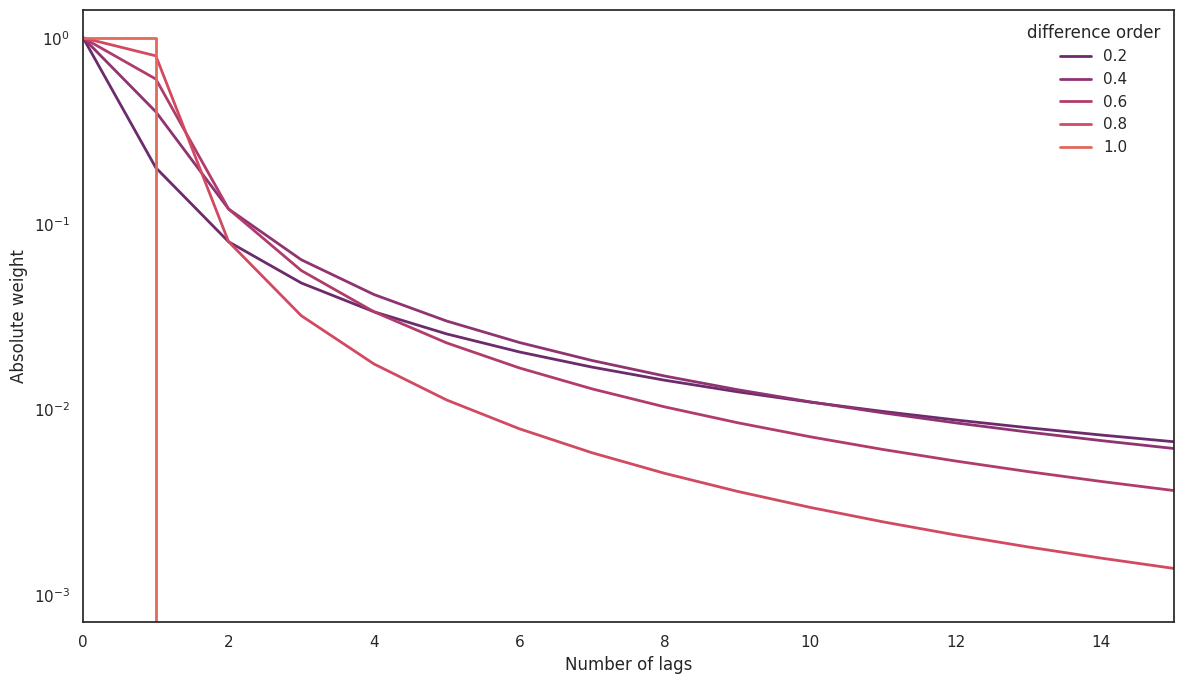

In [22]:
fig, axs = plt.subplots(1,1,figsize=(12,7))
axs = [axs]
for f in np.linspace(0.2,1, 5):
    axs[0].plot(np.abs(fracdiff._GetMemoryWeights(f, memoryThreshold=0.001))[::-1], label = f'{f:0.1f}', lw =2)
    axs[0].set_yscale('log')
    axs[0].set_xlim(0,15)
    if f == 1.0:
        axs[0].vlines(1, 0,1, color = 'C4', lw =2)
# axs[0].hlines([0.001], 0, 70, linestyle = '--', color ='black')
stat = []
corr = []
for f in np.linspace(0,1, 11):
    close_fdiff = fracdiff._FracDiff(df_to_fracdiff.iloc[:,-1:], order = f)
    adf = ADF(close_fdiff, method='aic')
    stat.append(adf.pvalue)
    corr.append(close_fdiff.corrwith(df_to_fracdiff["close"]).values[0])
plt.legend(title = 'difference order',loc = 'best', frameon = False, title_fontsize = 12)
plt.xlabel('Number of lags')
plt.ylabel("Absolute weight")
fig.tight_layout()
plt.savefig('./fracdiff_lags.png', dpi = 200, transparent = True)


### Plot 2 : Plot of the Pearson correlation with the original time series and ADF stationarity test $p_{val}$ by fractional differencing order. The selected order ($p_{val}=5\%$) is highlighted.

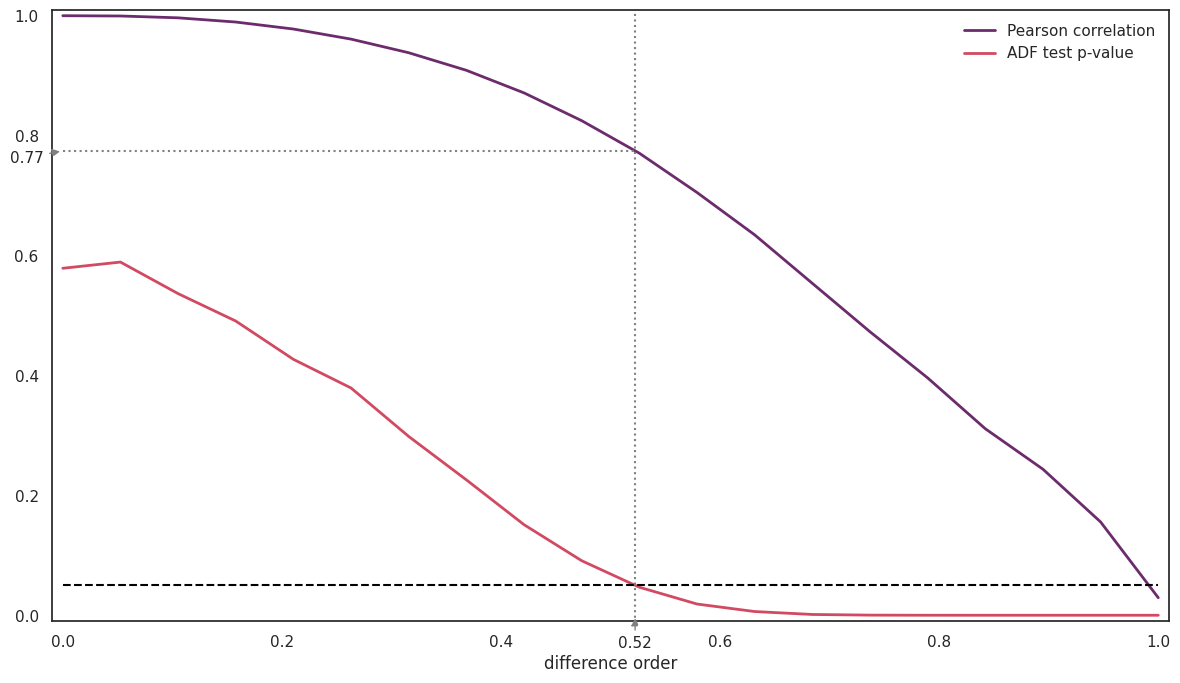

In [23]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

axs = [0,axs]

stat = []
corr = []
fs = np.linspace(0, 1, 20)
for f in fs:
    close_fdiff = fracdiff._FracDiff(df_to_fracdiff.iloc[:,-1:], order = f)
    adf = ADF(close_fdiff, method='aic')
    stat.append(adf.pvalue)
    corr.append(close_fdiff.corrwith(df_to_fracdiff["close"]).values[0])

# axs[1].plot(np.linspace(0,1, 11),corr)
# axs[1].plot(np.linspace(0,1, 11),stat)
# axs[1].hlines(0.05, 0,11, linestyle = '--', color = 'grey')
# axs[1].vlines(0.53, -1,1.5, linestyle = '--', color = 'grey')
# axs[1].set_xlim(-0.01,1.01)
# axs[1].set_ylim(-0.01,1.01)



stat_arr = np.array(stat)
corr_arr = np.array(corr)

# Find index where the crossing happens
cross_idx = np.where((stat_arr[:-1] > 0.05) & (stat_arr[1:] <= 0.05))[0]
if cross_idx.size == 0:
    print("No crossing found!")
    f_star = None
else:
    i = cross_idx[0]
    # Linear interpolation to find crossing
    f0, f1 = fs[i], fs[i+1]
    y0, y1 = stat_arr[i], stat_arr[i+1]

    # interpolation:
    f_star = f0 + (0.05 - y0) * (f1 - f0) / (y1 - y0)
    # Get corresponding corr value by linear interpolation as well
    corr_star = corr_arr[i] + (f_star - f0) * (corr_arr[i+1] - corr_arr[i]) / (f1 - f0)
axs[1].plot(fs, corr_arr, label = 'Pearson correlation', lw = 2, color = 'C0')
axs[1].plot(fs, stat_arr, label = 'ADF test p-value', lw =2, color = 'C3')
axs[1].hlines(0.05, 0, 1, linestyle='--', color='black', lw = 1.5)
if f_star is not None:
    axs[1].vlines(f_star, -1, 1.5, linestyle=':', color='grey', lw =1.5)
    axs[1].hlines(corr_star, 0, f_star, linestyle=':', color='grey', lw = 1.5)
    axs[1].annotate(
    f'{f_star:.2f}',
    xy=(f_star, 0),
    xycoords='data',
    xytext=(0, -15),
    textcoords='offset points',
    ha='center', va='top',
    fontsize=11,
    arrowprops=dict(arrowstyle='-|>', color='grey', lw=1, linestyle='--')
    )
    axs[1].annotate(
    f'{corr_star:.2f}',
    xy=(0, corr_star),
    xycoords='data',
    xytext=(-38, -5),
    textcoords='offset points',
    ha='left', va='center',
    fontsize=11,
    arrowprops=dict(arrowstyle='-|>', color='grey', lw=1, linestyle='--')
    )
axs[1].set_xlim(-0.01, 1.01)
axs[1].set_ylim(-0.01, 1.01)
axs[1].set_xlabel('difference order')
axs[1].legend(frameon = False)
fig.tight_layout()
plt.savefig('./fracdiff_correlation.png', dpi = 200, transparent = True)

### Plot 3 : Transformed Bitcoin Price chart for different fractional differencing orders $d \in (0,1]$

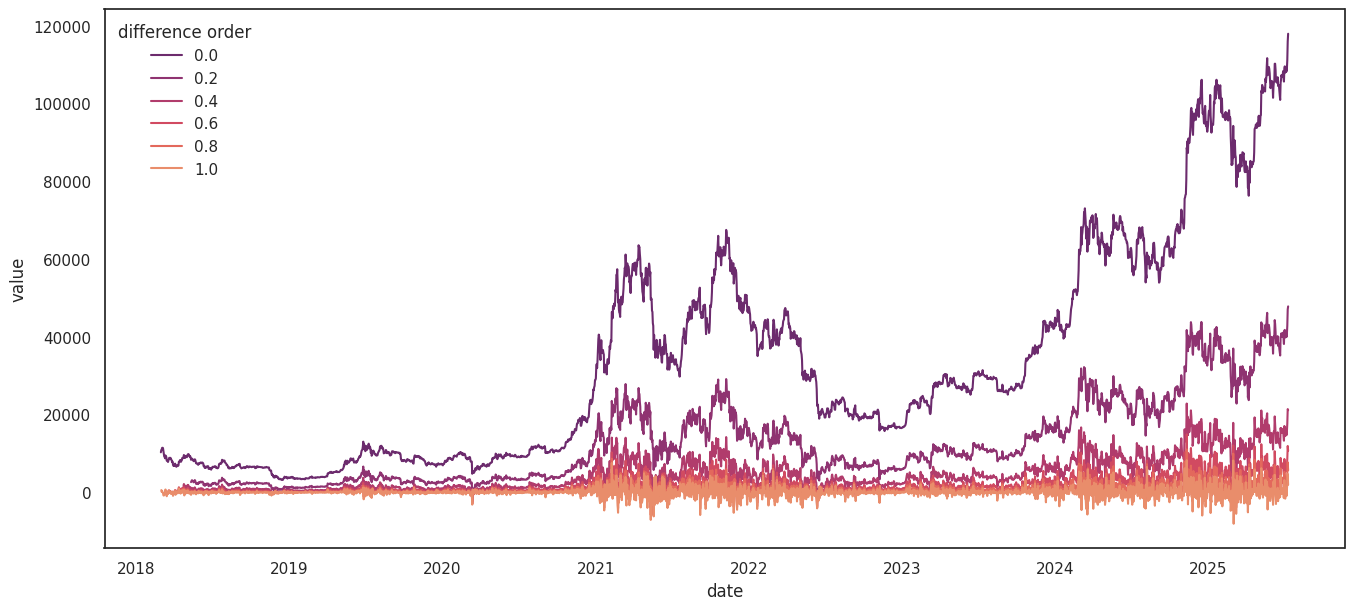

In [24]:
fig, ax = plt.subplots(1,1,figsize=(16,7))
ax.plot(df['close'], label = '0.0')
for f in np.linspace(0.2,1, 5):
    close_fdiff = fracdiff._FracDiff(df['close'], order = f)
    ax.plot(close_fdiff, label = f'{f:0.1f}')
plt.legend(title = 'difference order',loc = 'best', frameon = False, title_fontsize = 12)
plt.ylabel('value')
plt.xlabel('date')
plt.savefig('./fracdiff_curve.png', dpi = 200, transparent = True)
